In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import random as rng
from itertools import combinations
from scipy.ndimage import interpolation

from src.puzzle import Puzzle
from src.edge import Edge
from src.puzzle_solver import PuzzleSolver
from src.cfg import CFG

%load_ext autoreload
%autoreload 2

## Extract puzzles

In [2]:
def load_puzzles(path, bg_threshold=254, verbose=2):
    
    def get_segment_crop(img, mask, buffer=10):
        cropped = img[np.ix_(mask.any(1), mask.any(0))]

        size_x, size_y, channels = cropped.shape

        new_cropped = np.ones((size_x + 2 * buffer, size_y + 2 * buffer, channels), dtype=np.uint8) * 255
        new_cropped[buffer:size_x+buffer, buffer:size_y+buffer] = cropped

        return new_cropped

    bg_threshold = bg_threshold

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img[np.all(img == 0,axis=2)] = 255
    if verbose > 0:
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.show()

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    kernel = np.ones((5,5),np.uint8)

    gray_blurred = cv2.medianBlur(gray, ksize=1)
    thresh = cv2.threshold(gray_blurred, bg_threshold, 255, cv2.THRESH_BINARY)[1]
    thresh_blurred = cv2.blur(thresh, ksize=(3, 3))
    thresh_blurred = cv2.bitwise_not(thresh_blurred)
    thresh_blurred = cv2.morphologyEx(thresh_blurred, cv2.MORPH_OPEN, kernel, iterations=2)

    if verbose > 0:
        plt.figure(figsize=(10, 10))
        plt.imshow(thresh_blurred, cmap='gray')
        plt.show()

    drawing = np.zeros((thresh_blurred.shape[0], thresh_blurred.shape[1], 3), dtype=np.uint8)

    result = cv2.connectedComponents(thresh_blurred, drawing)
    puzzle_num = result[0]

    puzzles = []
    for puzzle_idx in range(1, puzzle_num+1):

        puzzle_img = get_segment_crop(img, result[1] == puzzle_idx)

        if puzzle_img.shape[0] < CFG['min_puzzle_width'] or puzzle_img.shape[1] < CFG['min_puzzle_width']:
            continue

        puzzle = Puzzle(puzzle_img, bg_threshold=bg_threshold)
        
        if verbose > 1:
            puzzle.draw_puzzle_analysis()
            print(puzzle_idx)
            plt.imshow(puzzle_img)
            plt.show()
        
        puzzles.append(puzzle)    

    edges = [e for p in puzzles for e in p.edges]
        
    return puzzles, edges

## Compute edge similarity

In [3]:
def get_rankings_for_solution(solution, edge_distance_dict):
    edge_pairs = []
    
    for row_idx in range(len(solution)):
        for col_idx in range(len(solution[row_idx])):
            u1, r1, b1, l1 = solution[row_idx][col_idx]
            if row_idx > 0:
                u2, r2, b2, l2 = solution[row_idx-1][col_idx]
                edge_pairs.append((u1, b2))
                
            if col_idx > 0:
                u2, r2, b2, l2 = solution[row_idx][col_idx-1]
                edge_pairs.append((l1, r2))
    
    rankings = []
    for solution_e1, solution_e2 in edge_pairs:
        e1_distances = [(e2, edge_distance_dict[(e1, e2)]) for e1, e2 in edge_distance_dict.keys() if solution_e1 == e1]
        e1_distances_sorted = sorted(e1_distances, key=lambda x: x[1])
        
        closest_edges = [e[0] for e in e1_distances_sorted]
        rankings.append(closest_edges.index(solution_e2))
        
    return rankings
        
def get_edge_distances(edges):
    edge_num = len(edges)
    edge_color_distance_dict = {}
    edge_affine_distance_dict = {}

    for idx_e1, e1 in tqdm(enumerate(edges), total=edge_num):
        for idx_e2, e2 in enumerate(edges):


            if not e1.can_be_connected_with(e2):
                continue

            color_distance = e1.color_segment_distance(e2)
            affine_distance = e1.affine_distance(e2, plot=False)

            edge_color_distance_dict[e1, e2] = color_distance
            edge_affine_distance_dict[e1, e2] = affine_distance
            
    return edge_color_distance_dict, edge_affine_distance_dict

def get_mean_distances(edge_color_distance_dict, edge_affine_distance_dict, color_weight=1.0, affine_weight=1.0):
    edge_distance_dict = {}

    for e1 in edges:
        for e2 in edges:
            edge_distance_dict[e1, e2] = 99999

            if not e1.can_be_connected_with(e2):
                continue

            edge_distance_dict[e1, e2] = (color_weight*edge_color_distance_dict[e1, e2]  
                                          + affine_weight*edge_affine_distance_dict[e1, e2])
            
    return edge_distance_dict

def get_all_distances(edges, edge_distance_dict):
    all_distances = []
    for e1 in edges:
        for e2 in edges:
            distance = edge_distance_dict[e1, e2]
            if e1.can_be_connected_with(e2):
                all_distances.append(distance)
    
    return all_distances

def get_solution_scores(solution, edge_distance_dict):
    edge_pairs = []
    
    for row_idx in range(len(solution)):
        for col_idx in range(len(solution[row_idx])):
            u1, r1, b1, l1 = solution[row_idx][col_idx]
            if row_idx > 0:
                u2, r2, b2, l2 = solution[row_idx-1][col_idx]
                edge_pairs.append((u1, b2))
                
            if col_idx > 0:
                u2, r2, b2, l2 = solution[row_idx][col_idx-1]
                edge_pairs.append((l1, r2))
                
    return [edge_distance_dict[e1, e2] for e1, e2 in edge_pairs]


## Load car puzzles

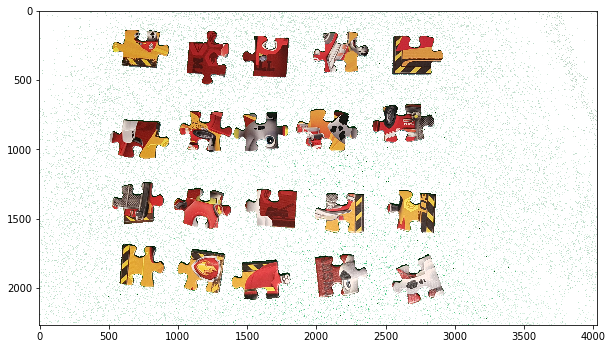

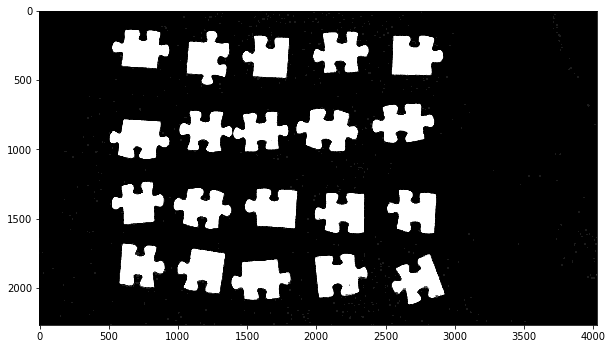

In [4]:
CFG['min_defect_distance'] = 2000
CFG['max_head_area'] = 0.15
CFG['puzzle_smooth_kernel'] = (12, 12)
CFG['puzzle_smooth_range_min'] = 0
CFG['puzzle_smooth_range_max'] = 5
CFG['corner_quality_level'] = 0.00002
CFG['corner_k'] = 0.00050
CFG['min_header_compactness'] = 0.069

puzzles, edges = load_puzzles('./img/cartoon_2_no_bg.png', verbose=1)

In [5]:
solution_idx = [
    [(3, 2), (17, 3), (1, 3), (12, 1)],
    [(19, 1), (8, 2), (11, 1), (18, 0)],
    [(15, 1), (6, 1), (7, 0), (9, 0)],
    [(0, 3), (2, 2), (5, 3), (13, 0)],
    [(16, 3), (14, 3), (10, 0), (4, 1)],
]

In [6]:
for i in range(0, len(edges), 4):
    if any(solved_idx == (i/4) for row in solution_idx for solved_idx, _ in row):
        continue
    edges[i].puzzle.draw_puzzle()
    print(i/4)

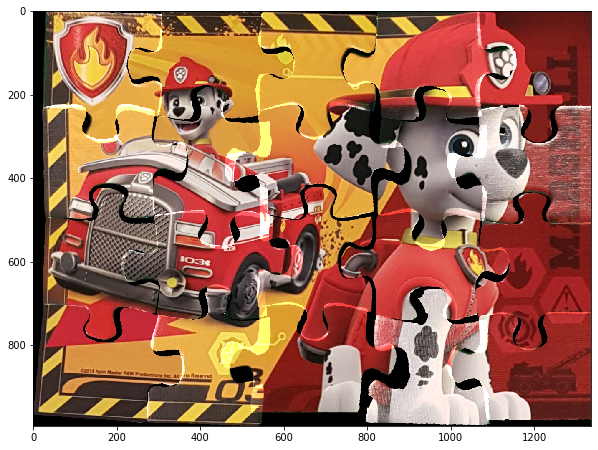

In [7]:
solution = []
edge_distance_dict = None
for row in solution_idx:
    solution.append([])
    for puzzle_idx, upper_edge_idx in row:
        idx = puzzle_idx * 4 + upper_edge_idx
        upper_edge = edges[idx]
        right_edge = upper_edge.next_edge
        bottom_edge = right_edge.next_edge
        left_edge = bottom_edge.next_edge
    
        solution[-1].append((upper_edge, right_edge, bottom_edge, left_edge))

ps = PuzzleSolver(puzzles, edge_distance_dict=edge_distance_dict, puzzles_size=(2000, 2000), verbose=False)
ps.draw_solution(solution)

## Dog

In [44]:
CFG['use_hsv'] = True
CFG['erosion_iterations'] = 2

CFG['num_segments'] = 30
CFG['color_array_thickness'] = 50
CFG['color_compare_pixel_width'] = 10

## Num segments experiments

In [10]:
results = {}

In [ ]:
for num_segments in [3,5,7] + list(range(10, 110, 10)):
    results[num_segments] = {}
    for hsv in [False, True]:
        results[num_segments][hsv] = {}
        for filter_size in [10, 20]:
            CFG['num_segments'] = num_segments
            CFG['use_hsv'] = hsv
            CFG['color_compare_pixel_width'] = filter_size

            edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)
            edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                                edge_affine_distance_dict, 
                                                color_weight=1.0, 
                                                affine_weight=0.0)

            solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
            all_scores = get_all_distances(edges, edge_distance_dict)
            solution_scores = get_solution_scores(solution, edge_distance_dict)

            results[num_segments][hsv][filter_size] = (solution_rankings, all_scores, solution_scores)

In [84]:
#pickle.dump(results, open('results_dog.p', 'wb'))
results = pickle.load(open('results_dog_color.p', 'rb'))

In [85]:
solution_rows, all_rows = [], []
for segment_len in results.keys():
    for is_hsv in results[segment_len].keys():
        for filter_size in results[segment_len][is_hsv].keys():
            for result_idx in range(len(results[segment_len][is_hsv][filter_size][0])):
                solution_score = results[segment_len][is_hsv][filter_size][2][result_idx]
                ranking = results[segment_len][is_hsv][filter_size][0][result_idx]
                solution_rows.append((segment_len, is_hsv, filter_size, solution_score, ranking))
            for all_scores_idx in range(len(results[segment_len][is_hsv][filter_size][1])):    
                all_score = results[segment_len][is_hsv][filter_size][1][all_scores_idx]
                all_rows.append((segment_len, is_hsv, filter_size, all_score))

solution_df = pd.DataFrame.from_records(solution_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'solution_score', 'ranking']
                                       )
all_df = pd.DataFrame.from_records(all_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'all_score']
                                       )

Text(0, 0.5, 'Średni ranking prawidłowego sąsiada')

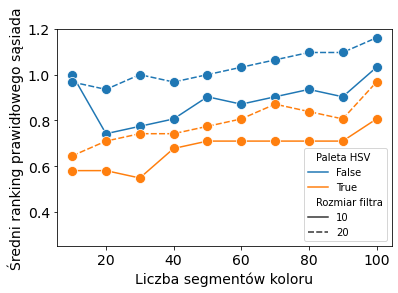

In [89]:
tex_fonts = {
    # Use LaTeX to write all text
    #"text.usetex": False,
    #"font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
}

plt.rcParams.update(tex_fonts)


zero_rankings = solution_df.groupby(['segment_len', 'hsv', 'filter_size']).ranking.agg(['mean']).reset_index()
zero_rankings.columns = ['segment_len', 'Paleta HSV', 'Rozmiar filtra', 'mean']
plt.figure(figsize=(6, 4))
#sns.set(font_scale=1.0)
sns.lineplot(x="segment_len", y="mean", hue='Paleta HSV', style='Rozmiar filtra', data=zero_rankings, marker="o", markersize=10)

plt.ylim(0.25, 1.2)
plt.xlabel('Liczba segmentów koloru')
plt.ylabel('Średni ranking prawidłowego sąsiada')

## Filter size experiments

In [82]:
results = {}

In [83]:
for num_segments in [10, 20]:
    results[num_segments] = {}
    for hsv in [True]:
        results[num_segments][hsv] = {}
        for filter_size in range(5, 35, 5):
            CFG['num_segments'] = num_segments
            CFG['use_hsv'] = hsv
            CFG['color_compare_pixel_width'] = filter_size

            edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)
            edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                                edge_affine_distance_dict, 
                                                color_weight=1.0, 
                                                affine_weight=0.0)

            solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
            all_scores = get_all_distances(edges, edge_distance_dict)
            solution_scores = get_solution_scores(solution, edge_distance_dict)

            results[num_segments][hsv][filter_size] = (solution_rankings, all_scores, solution_scores)

100%|██████████| 80/80 [02:01<00:00,  1.52s/it]


In [92]:
#pickle.dump(results, open('results_dog_filter_size.p', 'wb'))
results = pickle.load(open('results_dog_filter_size.p', 'rb'))

In [93]:
solution_rows, all_rows = [], []
for segment_len in results.keys():
    for is_hsv in results[segment_len].keys():
        for filter_size in results[segment_len][is_hsv].keys():
            for result_idx in range(len(results[segment_len][is_hsv][filter_size][0])):
                solution_score = results[segment_len][is_hsv][filter_size][2][result_idx]
                ranking = results[segment_len][is_hsv][filter_size][0][result_idx]
                solution_rows.append((segment_len, is_hsv, filter_size, solution_score, ranking))
            for all_scores_idx in range(len(results[segment_len][is_hsv][filter_size][1])):    
                all_score = results[segment_len][is_hsv][filter_size][1][all_scores_idx]
                all_rows.append((segment_len, is_hsv, filter_size, all_score))

solution_df = pd.DataFrame.from_records(solution_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'solution_score', 'ranking']
                                       )
all_df = pd.DataFrame.from_records(all_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'all_score']
                                       )

Text(0, 0.5, 'Średni ranking prawidłowego sąsiada')

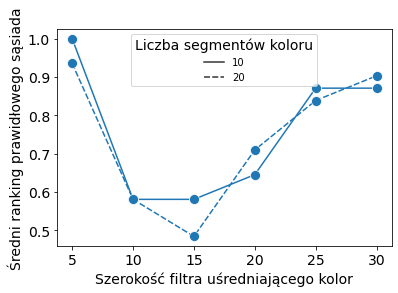

In [94]:
zero_rankings = solution_df.groupby(['segment_len', 'hsv', 'filter_size']).ranking.agg(['mean']).reset_index()
zero_rankings.columns = ['Liczba segmentów koloru', 'Paleta HSV', 'Rozmiar filtra', 'mean']
plt.figure(figsize=(6,4))
#sns.set(font_scale=1.5)
sns.lineplot(x="Rozmiar filtra", y="mean", style='Liczba segmentów koloru', data=zero_rankings, marker="o", markersize=10)

plt.xlabel('Szerokość filtra uśredniającego kolor')

plt.ylabel('Średni ranking prawidłowego sąsiada')

## Distribution of edge distances

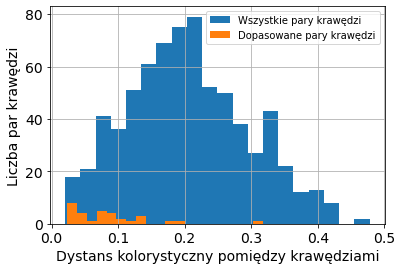

In [95]:

plt.figure(figsize=(6, 4))

best_solution_all_scores = all_df[(all_df.segment_len == 20) & (all_df.filter_size == 15)]
best_solution_all_scores.all_score.hist(bins=20, label='Wszystkie pary krawędzi')
#plt.show()

best_solution_scores = solution_df[(solution_df.segment_len == 20) & (solution_df.filter_size == 15)]
best_solution_scores.solution_score.hist(bins=20, label='Dopasowane pary krawędzi')

plt.ylabel('Liczba par krawędzi')
plt.xlabel('Dystans kolorystyczny pomiędzy krawędziami')
plt.legend()
plt.show()

Text(0, 0.5, 'Liczba krawędzi')

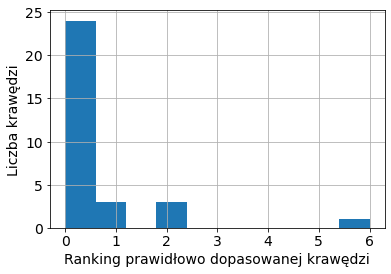

In [96]:
plt.figure(figsize=(6, 4))

best_solution_scores.ranking.hist()
plt.xlabel('Ranking prawidłowo dopasowanej krawędzi')
plt.ylabel('Liczba krawędzi')

## Affine distance weight 

In [126]:
results = {}

In [127]:
CFG['num_segments'] = 20
CFG['use_hsv'] = True
CFG['color_compare_pixel_width'] = 15

edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)

100%|██████████| 80/80 [00:49<00:00,  1.60it/s]


In [128]:
for affine_weight in [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]:
    edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                        edge_affine_distance_dict, 
                                        color_weight=1, 
                                        affine_weight=affine_weight)

    solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
    all_scores = get_all_distances(edges, edge_distance_dict)
    solution_scores = get_solution_scores(solution, edge_distance_dict)

    results[affine_weight] = (solution_rankings, all_scores, solution_scores)
    
    
edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                    edge_affine_distance_dict, 
                                    color_weight=0.0, 
                                    affine_weight=1.0)

solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
all_scores = get_all_distances(edges, edge_distance_dict)
solution_scores = get_solution_scores(solution, edge_distance_dict)
    
only_affine = (solution_rankings, all_scores, solution_scores)

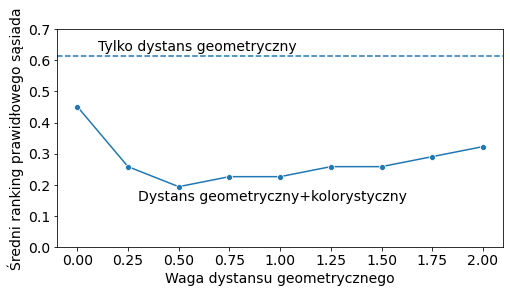

In [129]:
rows = []

for affine_weight in results.keys():
    mean_ranking = np.mean(results[affine_weight][0])
    rows.append((affine_weight, mean_ranking))
    
rows_df = pd.DataFrame.from_records(rows,columns=['affine_weight', 'mean_ranking'])

plt.figure(figsize=(8, 4))

ax = sns.lineplot(x="affine_weight", y="mean_ranking", data=rows_df, marker="o")
ax.text(0.1,0.63, "Tylko dystans geometryczny")
ax.text(0.3,0.15, "Dystans geometryczny+kolorystyczny")
ax.axhline(np.mean(only_affine[0]), ls='--')

plt.ylim(0, 0.7)
plt.ylabel('Średni ranking prawidłowego sąsiada')
plt.xlabel('Waga dystansu geometrycznego')
plt.show()

## Solving

In [45]:
edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:40<00:00,  1.97it/s]


In [46]:
edge_distance_dict = get_mean_distances(edge_color_distance_dict, edge_affine_distance_dict, 1.0, 0.5)

Number of backtracks:  0


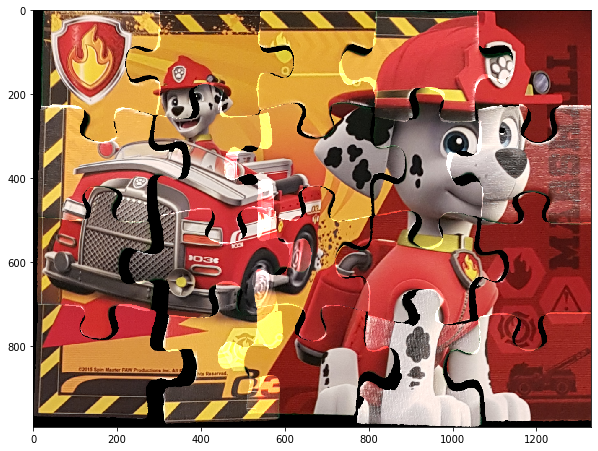

In [49]:
ps = PuzzleSolver(puzzles, 
                  puzzles_size=(1500, 1500), 
                  edge_distance_dict=edge_distance_dict, 
                  distance_maximum=0.7, 
                  min_puzzle_show=None,
                  verbose=False)
res = ps.solve()

## Donkey

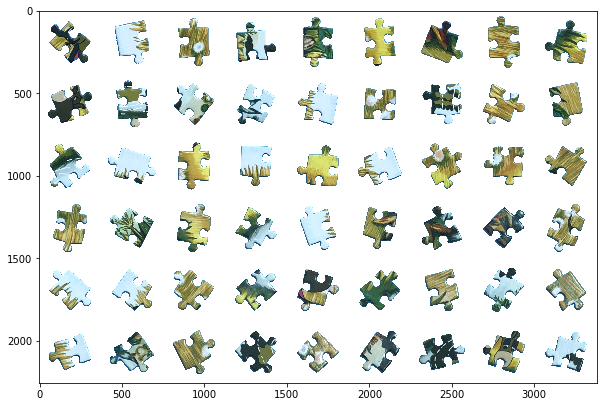

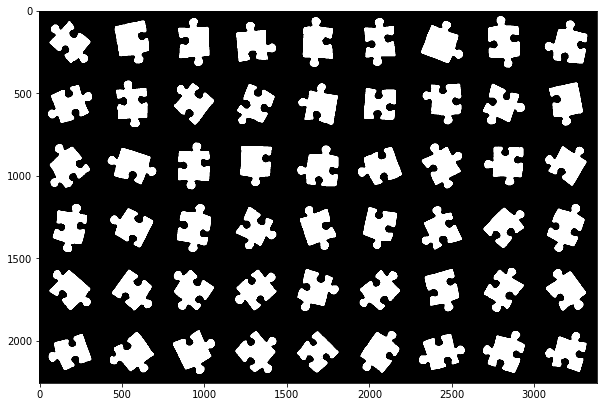

In [50]:
CFG['min_defect_distance'] = 1300
CFG['max_head_area'] = 0.1
CFG['puzzle_smooth_kernel'] = (1, 1)
CFG['puzzle_smooth_range_min'] = 0
CFG['puzzle_smooth_range_max'] = 5
CFG['corner_quality_level'] = 0.00002
CFG['corner_k'] = 0.0000050
CFG['min_header_compactness'] = 0.069

puzzles, edges = load_puzzles('./img/1_cropped.png', verbose=1)

In [51]:
solution_idx = [
    [(5, 0), (2, 1), (49, 1), (23, 2), (33, 3), (6, 2)],
    [(12, 2), (0, 0), (19, 1), (4, 2), (31, 3), (34, 3)],
    [(25, 2), (14, 0), (21, 3), (32, 1), (15, 3), (50, 0)],
    [(30, 0), (29, 3), (3, 0), (20, 1), (51, 0), (11, 1)],
    [(40, 1), (7, 0), (48, 1), (9, 3), (13, 2), (47, 2)],
    [(26, 2), (37, 0), (16, 0), (53, 1), (46, 2), (8, 2)],
    [(52, 2), (43, 2), (18, 0), (41, 0), (36, 0), (35, 1)],
    [(42, 2), (27, 3), (24, 1), (28, 2), (44, 2), (1, 2)],
    [(22, 2), (45, 1), (17, 2), (39, 3), (38, 2), (10,3)],
    
]

In [52]:
for i in range(0, len(edges), 4):
    if any(solved_idx == (i/4) for row in solution_idx for solved_idx, _ in row):
        continue
    edges[i].puzzle.draw_puzzle()
    print(i/4)

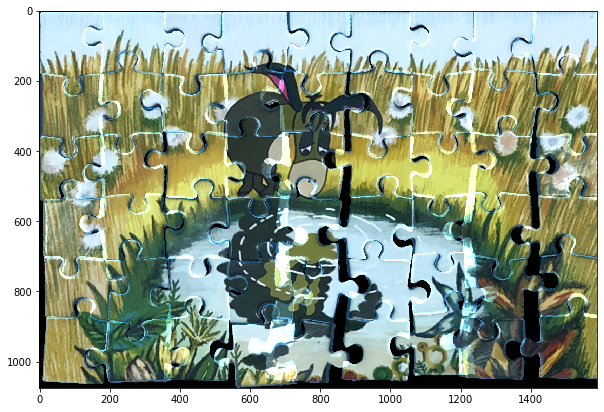

In [54]:
solution = []
edge_distance_dict = None

for row in solution_idx:
    solution.append([])
    for puzzle_idx, upper_edge_idx in row:
        idx = puzzle_idx * 4 + upper_edge_idx
        upper_edge = edges[idx]
        right_edge = upper_edge.next_edge
        bottom_edge = right_edge.next_edge
        left_edge = bottom_edge.next_edge
    
        solution[-1].append((upper_edge, right_edge, bottom_edge, left_edge))

ps = PuzzleSolver(puzzles, edge_distance_dict=None, puzzles_size=(1800, 1800), verbose=False)
ps.draw_solution(solution)

In [55]:
# solved parameters

CFG['use_hsv'] = False
CFG['erosion_iterations'] = 3

CFG['num_segments'] = 20
CFG['color_array_thickness'] = 50
CFG['color_compare_pixel_width'] = 20

In [56]:
results = {}

In [59]:
for num_segments in range(10, 110, 10):
    results[num_segments] = {}
    for hsv in [False, True]:
        results[num_segments][hsv] = {}
        for filter_size in [10, 20]:
            CFG['num_segments'] = num_segments
            CFG['use_hsv'] = hsv
            CFG['color_compare_pixel_width'] = filter_size

            edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)
            edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                                edge_affine_distance_dict, 
                                                color_weight=1.0, 
                                                affine_weight=0.0)

            solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
            all_scores = get_all_distances(edges, edge_distance_dict)
            solution_scores = get_solution_scores(solution, edge_distance_dict)

            results[num_segments][hsv][filter_size] = (solution_rankings, all_scores, solution_scores)


 44%|████████████████████████████████████████████████████████████████████▉                                                                                      | 96/216 [02:01<01:31,  1.31it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 189/216 [04:01<00:32,  1.21s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:34<00:00,  1.27s/it]

 32%|██████████████████████████████████████████████████▏                                                                                                        | 70/216 [02:43<05:43,  2.35s/it]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 164/216 [06:22<01:35,  1.84s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [08:31<00:00,  2.37s/it]

 20%|███████████████████████████████▌                                                                                                                           | 44/216 [01:02<03:18,  1.15s/it]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 135/216 [03:30<01:42,  1.27s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:14<00:00,  1.45s/it]

  6%|██████████                                                                                                                                                 | 14/216 [00:29<08:55,  2.65s/it]


 51%|███████████████████████████████████████████████████████████████████████████████▏                                                                          | 111/216 [04:11<05:06,  2.91s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 205/216 [07:53<00:25,  2.31s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [08:22<00:00,  2.33s/it]

 38%|███████████████████████████████████████████████████████████▌                                                                                               | 83/216 [01:56<04:31,  2.04s/it]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 178/216 [04:05<01:09,  1.82s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:54<00:00,  1.37s/it]

 27%|██████████████████████████████████████████▎                                                                                                                | 59/216 [02:12<10:16,  3.93s/it]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 151/216 [06:28<03:33,  3.28s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [08:50<00:00,  2.46s/it]

 14%|██████████████████████▏                                                                                                                                    | 31/216 [00:43<04:20,  1.41s/it]


 58%|█████████████████████████████████████████████████████████████████████████████████████████                                                                 | 125/216 [03:17<02:20,  1.55s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:30<00:00,  1.53s/it]

  1%|█▍                                                                                                                                                          | 2/216 [00:07<12:32,  3.52s/it]


 46%|███████████████████████████████████████████████████████████████████████                                                                                    | 99/216 [04:17<05:32,  2.84s/it]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 193/216 [08:01<00:40,  1.78s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [09:00<00:00,  2.50s/it]

 34%|████████████████████████████████████████████████████▍                                                                                                      | 73/216 [01:53<04:37,  1.94s/it]


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 167/216 [04:24<01:20,  1.64s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:43<00:00,  1.59s/it]

 31%|█████████████████████████████▎                                                                  | 66/216 [02:18<07:43,  3.09s/it]


 93%|████████████████████████████████████████████████████████████████████████████████████████▍      | 201/216 [07:05<00:23,  1.55s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:38<00:00,  2.12s/it]

 56%|█████████████████████████████████████████████████████▏                                         | 121/216 [02:50<02:43,  1.72s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:12<00:00,  1.45s/it]

 20%|███████████████████▌                                                                            | 44/216 [01:37<05:09,  1.80s/it]


 82%|██████████████████████████████████████████████████████████████████████████████▎                | 178/216 [07:15<01:48,  2.87s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [08:34<00:00,  2.38s/it]

 46%|████████████████████████████████████████████                                                    | 99/216 [02:08<02:59,  1.54s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:39<00:00,  1.30s/it]

  8%|███████▌                                                                                        | 17/216 [00:39<10:40,  3.22s/it]


 72%|████████████████████████████████████████████████████████████████████▏                          | 155/216 [05:34<02:33,  2.52s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:35<00:00,  2.11s/it]

 35%|█████████████████████████████████▊                                                              | 76/216 [01:41<04:17,  1.84s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████▏ | 212/216 [04:46<00:05,  1.32s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:54<00:00,  1.36s/it]

 61%|█████████████████████████████████████████████████████████▌                                     | 131/216 [04:53<04:13,  2.98s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:42<00:00,  2.14s/it]

 25%|████████████████████████▍                                                                       | 55/216 [01:01<04:22,  1.63s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 188/216 [04:07<00:44,  1.61s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:42<00:00,  1.31s/it]

 51%|████████████████████████████████████████████████▍                                              | 110/216 [03:49<04:29,  2.55s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:33<00:00,  2.10s/it]

 14%|█████████████▎                                                                                  | 30/216 [00:37<03:26,  1.11s/it]


 77%|█████████████████████████████████████████████████████████████████████████                      | 166/216 [03:46<01:13,  1.47s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:55<00:00,  1.37s/it]

 39%|█████████████████████████████████████▊                                                          | 85/216 [03:11<06:55,  3.17s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:46<00:00,  2.16s/it]

  2%|█▊                                                                                               | 4/216 [00:08<07:07,  2.01s/it]


 66%|██████████████████████████████████████████████████████████████▍                                | 142/216 [03:09<01:13,  1.00it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:45<00:00,  1.32s/it]

 30%|████████████████████████████▍                                                                   | 64/216 [02:09<07:50,  3.10s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████▌       | 199/216 [06:58<00:26,  1.54s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:35<00:00,  2.11s/it]

 55%|████████████████████████████████████████████████████▎                                          | 119/216 [02:47<03:18,  2.05s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:56<00:00,  1.37s/it]

 19%|█████████████████▊                                                                              | 40/216 [01:23<08:11,  2.79s/it]


 81%|█████████████████████████████████████████████████████████████████████████████▍                 | 176/216 [06:23<01:58,  2.95s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:50<00:00,  2.18s/it]

 45%|███████████████████████████████████████████                                                     | 97/216 [02:09<02:18,  1.17s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:06<00:00,  1.42s/it]

  7%|██████▋                                                                                         | 15/216 [00:56<10:53,  3.25s/it]


 70%|██████████████████████████████████████████████████████████████████▊                            | 152/216 [06:01<03:12,  3.00s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [08:07<00:00,  2.26s/it]

 34%|████████████████████████████████▉                                                               | 74/216 [01:41<04:02,  1.71s/it]


 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 209/216 [04:50<00:09,  1.42s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:01<00:00,  1.39s/it]

 60%|████████████████████████████████████████████████████████▋                                      | 129/216 [04:55<04:15,  2.93s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [08:08<00:00,  2.26s/it]

 25%|███████████████████████▌                                                                        | 53/216 [00:59<03:28,  1.28s/it]


 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 186/216 [04:07<00:41,  1.40s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:46<00:00,  1.32s/it]

 50%|███████████████████████████████████████████████▌                                               | 108/216 [03:43<03:20,  1.86s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:34<00:00,  2.10s/it]

 12%|███████████▌                                                                                    | 26/216 [00:33<02:28,  1.28it/s]


 76%|████████████████████████████████████████████████████████████████████████▏                      | 164/216 [03:45<00:52,  1.01s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:59<00:00,  1.39s/it]

 38%|████████████████████████████████████▉                                                           | 83/216 [03:05<06:57,  3.14s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:49<00:00,  2.17s/it]

  1%|▉                                                                                                | 2/216 [00:04<07:18,  2.05s/it]


 65%|█████████████████████████████████████████████████████████████▌                                 | 140/216 [03:11<01:12,  1.04it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:48<00:00,  1.34s/it]

 29%|███████████████████████████▌                                                                    | 62/216 [02:03<08:23,  3.27s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 196/216 [07:00<00:53,  2.68s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:38<00:00,  2.12s/it]

 54%|███████████████████████████████████████████████████▍                                           | 117/216 [02:47<03:22,  2.05s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:00<00:00,  1.39s/it]

 18%|████████████████▉                                                                               | 38/216 [01:16<06:34,  2.21s/it]


 81%|████████████████████████████████████████████████████████████████████████████▌                  | 174/216 [06:18<01:49,  2.60s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:51<00:00,  2.18s/it]

 44%|█████████████████████████████████████████▊                                                      | 94/216 [02:08<02:13,  1.09s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [04:51<00:00,  1.35s/it]

  6%|█████▊                                                                                          | 13/216 [00:25<07:46,  2.30s/it]


 69%|█████████████████████████████████████████████████████████████████▉                             | 150/216 [05:27<03:15,  2.96s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:40<00:00,  2.13s/it]

 33%|████████████████████████████████                                                                | 72/216 [01:37<03:08,  1.31s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████    | 207/216 [04:50<00:16,  1.79s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [05:04<00:00,  1.41s/it]

 59%|███████████████████████████████████████████████████████▊                                       | 127/216 [04:47<04:04,  2.74s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [07:52<00:00,  2.19s/it]


In [117]:
#pickle.dump(results, open('results2.p', 'wb'))
results = pickle.load(open('results_mule_color.p', 'rb'))
del results[5]
del results[15]

<AxesSubplot:xlabel='segment_len', ylabel='ranking'>

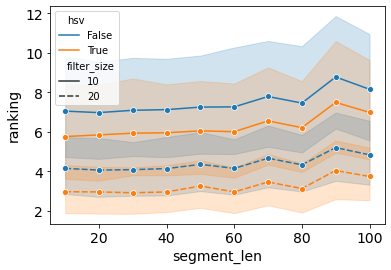

In [118]:
solution_rows, all_rows = [], []
for segment_len in results.keys():
    for is_hsv in results[segment_len].keys():
        for filter_size in results[segment_len][is_hsv].keys():
            for result_idx in range(len(results[segment_len][is_hsv][filter_size][0])):
                solution_score = results[segment_len][is_hsv][filter_size][2][result_idx]
                ranking = results[segment_len][is_hsv][filter_size][0][result_idx]
                solution_rows.append((segment_len, is_hsv, filter_size, solution_score, ranking))
            for all_scores_idx in range(len(results[segment_len][is_hsv][filter_size][1])):    
                all_score = results[segment_len][is_hsv][filter_size][1][all_scores_idx]
                all_rows.append((segment_len, is_hsv, filter_size, all_score))

solution_df = pd.DataFrame.from_records(solution_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'solution_score', 'ranking']
                                       )
all_df = pd.DataFrame.from_records(all_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'all_score']
                                       )

sns.lineplot(x="segment_len", y="ranking", hue='hsv', style='filter_size', data=solution_df, marker="o")

(-2.0, 9.0)

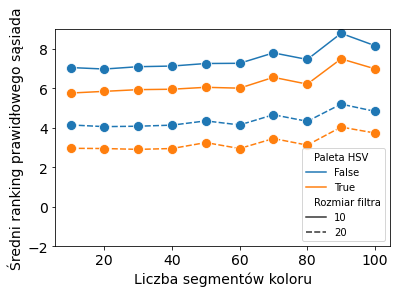

In [119]:
zero_rankings = solution_df.groupby(['segment_len', 'hsv', 'filter_size']).ranking.agg(['mean']).reset_index()
zero_rankings.columns = ['segment_len', 'Paleta HSV', 'Rozmiar filtra', 'mean']
plt.figure(figsize=(6,4))
#sns.set(font_scale=2.0)
sns.lineplot(x="segment_len", y="mean", hue='Paleta HSV', style='Rozmiar filtra', data=zero_rankings, marker="o", markersize=10)

plt.xlabel('Liczba segmentów koloru')
plt.ylabel('Średni ranking prawidłowego sąsiada')
plt.ylim(-2, 9)

## Filter size experiments

In [154]:
results = {}

In [155]:
for num_segments in [10, 20]:
    results[num_segments] = {}
    for hsv in [True]:
        results[num_segments][hsv] = {}
        for filter_size in range(5, 35, 5):
            CFG['num_segments'] = num_segments
            CFG['use_hsv'] = hsv
            CFG['color_compare_pixel_width'] = filter_size

            edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)
            edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                                edge_affine_distance_dict, 
                                                color_weight=1.0, 
                                                affine_weight=0.0)

            solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
            all_scores = get_all_distances(edges, edge_distance_dict)
            solution_scores = get_solution_scores(solution, edge_distance_dict)

            results[num_segments][hsv][filter_size] = (solution_rankings, all_scores, solution_scores)

100%|██████████| 216/216 [12:41<00:00,  3.52s/it]


In [120]:
#pickle.dump(results, open('results_mule_filter_size.p', 'wb'))
results = pickle.load(open('results_mule_filter_size.p', 'rb'))

In [121]:
solution_rows, all_rows = [], []
for segment_len in results.keys():
    for is_hsv in results[segment_len].keys():
        for filter_size in results[segment_len][is_hsv].keys():
            for result_idx in range(len(results[segment_len][is_hsv][filter_size][0])):
                solution_score = results[segment_len][is_hsv][filter_size][2][result_idx]
                ranking = results[segment_len][is_hsv][filter_size][0][result_idx]
                solution_rows.append((segment_len, is_hsv, filter_size, solution_score, ranking))
            for all_scores_idx in range(len(results[segment_len][is_hsv][filter_size][1])):    
                all_score = results[segment_len][is_hsv][filter_size][1][all_scores_idx]
                all_rows.append((segment_len, is_hsv, filter_size, all_score))

solution_df = pd.DataFrame.from_records(solution_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'solution_score', 'ranking']
                                       )
all_df = pd.DataFrame.from_records(all_rows, 
                                        columns=['segment_len', 'hsv', 'filter_size', 'all_score']
                                       )

Text(0, 0.5, 'Średni ranking prawidłowego sąsiada')

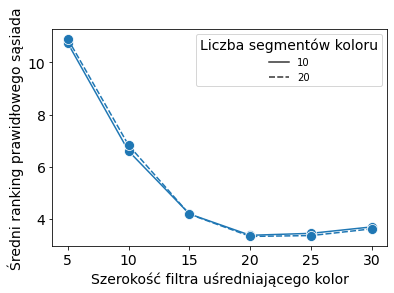

In [122]:
zero_rankings = solution_df.groupby(['segment_len', 'hsv', 'filter_size']).ranking.agg(['mean']).reset_index()
zero_rankings.columns = ['Liczba segmentów koloru', 'Paleta HSV', 'Rozmiar filtra', 'mean']
plt.figure(figsize=(6,4))
#sns.set(font_scale=1.5)
sns.lineplot(x="Rozmiar filtra", y="mean", style='Liczba segmentów koloru', data=zero_rankings, marker="o", markersize=10)

plt.xlabel('Szerokość filtra uśredniającego kolor')

plt.ylabel('Średni ranking prawidłowego sąsiada')

## Distribution of distances

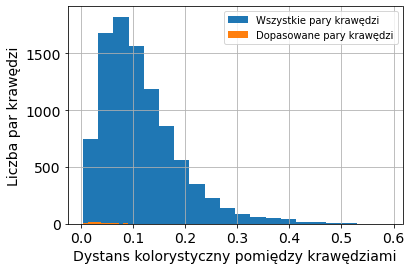

In [123]:
plt.figure(figsize=(6, 4))

best_solution_all_scores = all_df[(all_df.segment_len == 10) & (all_df.filter_size == 20)]
best_solution_all_scores.all_score.hist(bins=20, label='Wszystkie pary krawędzi')
#plt.show()

best_solution_scores = solution_df[(solution_df.segment_len == 20) & (solution_df.filter_size == 15)]
best_solution_scores.solution_score.hist(bins=20, label='Dopasowane pary krawędzi')

plt.ylabel('Liczba par krawędzi')
plt.xlabel('Dystans kolorystyczny pomiędzy krawędziami')
plt.legend()
plt.show()

Text(0, 0.5, 'Liczba krawędzi')

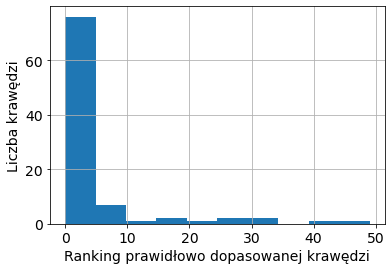

In [124]:
plt.figure(figsize=(6, 4))

best_solution_scores.ranking.hist()
plt.xlabel('Ranking prawidłowo dopasowanej krawędzi')
plt.ylabel('Liczba krawędzi')

## Affine distance weight

In [101]:
results = {}

In [58]:
CFG['num_segments'] = 20
CFG['use_hsv'] = True
CFG['color_compare_pixel_width'] = 20

edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)

100%|██████████| 216/216 [08:46<00:00,  2.44s/it]


In [102]:
for affine_weight in [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]:
    edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                        edge_affine_distance_dict, 
                                        color_weight=1, 
                                        affine_weight=affine_weight)

    solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
    all_scores = get_all_distances(edges, edge_distance_dict)
    solution_scores = get_solution_scores(solution, edge_distance_dict)

    results[affine_weight] = (solution_rankings, all_scores, solution_scores)
    
    
edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                    edge_affine_distance_dict, 
                                    color_weight=0.0, 
                                    affine_weight=1.0)

solution_rankings = get_rankings_for_solution(solution, edge_distance_dict)
all_scores = get_all_distances(edges, edge_distance_dict)
solution_scores = get_solution_scores(solution, edge_distance_dict)
    
only_affine = (solution_rankings, all_scores, solution_scores)

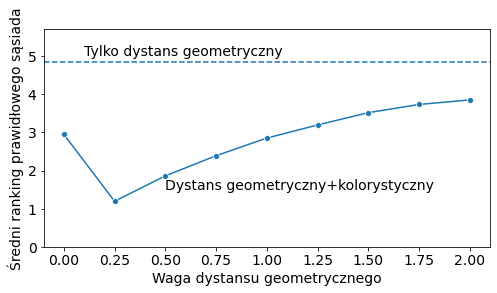

In [105]:
rows = []


for affine_weight in results.keys():
    mean_ranking = np.mean(results[affine_weight][0])
    rows.append((affine_weight, mean_ranking))
    
rows_df = pd.DataFrame.from_records(rows,columns=['affine_weight', 'mean_ranking'])

plt.figure(figsize=(8, 4))

ax = sns.lineplot(x="affine_weight", y="mean_ranking", data=rows_df, marker="o")
ax.text(0.1,5.0, "Tylko dystans geometryczny")
ax.text(0.5,1.5, "Dystans geometryczny+kolorystyczny")
ax.axhline(np.mean(only_affine[0]), ls='--')

plt.ylim(0, 5.7)
plt.ylabel('Średni ranking prawidłowego sąsiada')
plt.xlabel('Waga dystansu geometrycznego')
plt.show()

## Solving

In [57]:
CFG['num_segments'] = 20
CFG['use_hsv'] = True
CFG['color_compare_pixel_width'] = 20
edge_color_distance_dict, edge_affine_distance_dict = get_edge_distances(edges)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [10:01<00:00,  2.78s/it]


In [58]:
edge_distance_dict = get_mean_distances(edge_color_distance_dict, 
                                        edge_affine_distance_dict, 
                                        color_weight=1.0, 
                                        affine_weight=0.25)

Number of backtracks:  1


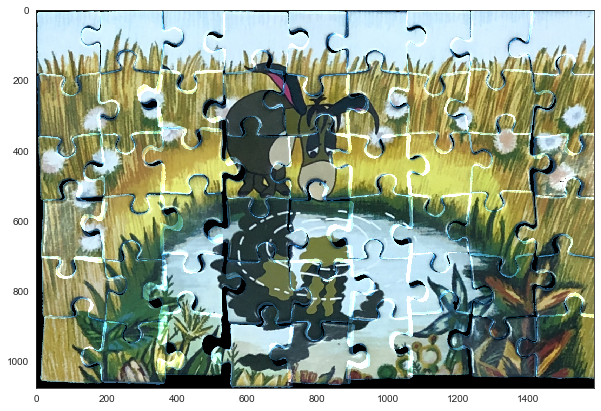

In [61]:
sns.set_style("white")
ps = PuzzleSolver(puzzles, 
                  puzzles_size=(1800, 1800), 
                  edge_distance_dict=edge_distance_dict, 
                  distance_maximum=1.0, 
                  min_puzzle_show=None,
                 verbose=False)
res = ps.solve()